In [1]:
import duckdb
cn = duckdb.connect("pp_grid_data.db") 
cn.execute("""
           INSTALL https;
           LOAD https;
           INSTALL excel;
           LOAD excel;
           """)

In [3]:
sql = """
    create or replace table pp_data
    as
    select "Plant file sequence number" as txn_id, "Data Year" as data_year
        , "Plant state abbreviation" as state_abbr
        , try_cast("Plant latitude" as float) as latitude
        , try_cast("Plant longitude" as float) as longitude
        , "Plant primary fuel" as fuel_type
        , "Plant primary fuel category" as fuel_category
    from read_xlsx('https://www.epa.gov/system/files/documents/2025-06/egrid2023_data_rev2.xlsx', sheet='PLNT23')
    where try_cast("Plant latitude" as float) is not null
"""

cn.sql(sql)

In [3]:
cn.sql("select fuel_type, fuel_category,  count(*) from pp_data group by all order by 3 desc limit 5").show(max_rows=100)

┌───────────┬───────────────┬──────────────┐
│ fuel_type │ fuel_category │ count_star() │
│  varchar  │    varchar    │    int64     │
├───────────┼───────────────┼──────────────┤
│ SUN       │ SOLAR         │         5658 │
│ NG        │ GAS           │         1993 │
│ WAT       │ HYDRO         │         1459 │
│ WND       │ WIND          │         1334 │
│ DFO       │ OIL           │          827 │
└───────────┴───────────────┴──────────────┘



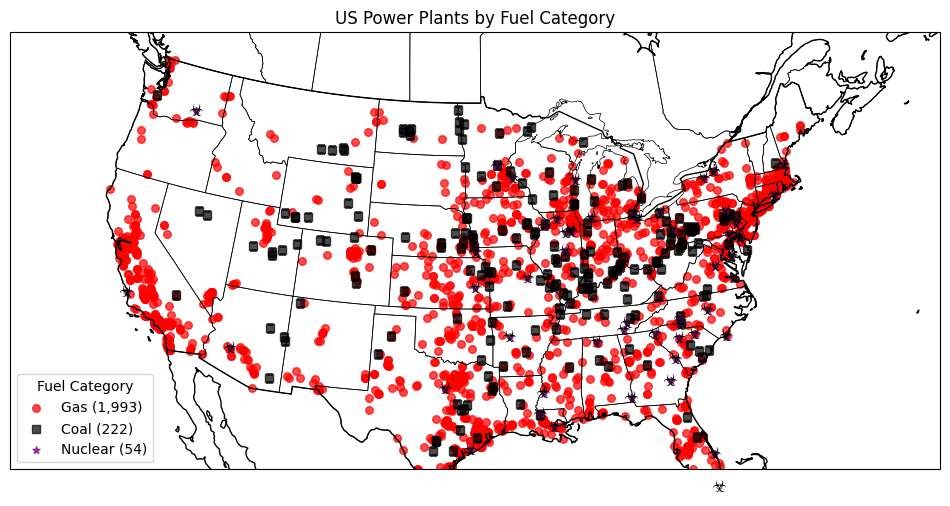

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

selected_fuels = [
        "GAS", 
        #"WIND", 
        "COAL", 
        "NUCLEAR", 
        #"SOLAR", 
        #"HYDRO"
]
query = f"""
    SELECT fuel_category, latitude, longitude
    FROM pp_data
    WHERE fuel_category IN ({', '.join([f'\'{f}\'' for f in selected_fuels])})
      AND latitude IS NOT NULL AND longitude IS NOT NULL
"""

df = cn.sql(query).df()

marker_map = {"NUCLEAR": "*","COAL": "s","GAS": "o","WIND": "^","SOLAR": "P","HYDRO": "D"}
color_map = {"NUCLEAR": "purple","COAL": "black","GAS": "red","WIND": "blue","SOLAR": "orange","HYDRO": "cyan"}

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.Geodetic())
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

legend_labels = []
for fuel in selected_fuels:
    subset = df[df["fuel_category"] == fuel]
    count = len(subset)
    ax.scatter(subset["longitude"], subset["latitude"],
               color=color_map[fuel],
               marker=marker_map[fuel],
               label=fuel.title(),
               s=30,
               alpha=0.7,
               transform=ccrs.Geodetic())
    legend_labels.append(f"{fuel.title()} ({count:,})")

    # Annotate nuclear plants with biohazard symbol
    if fuel == "NUCLEAR":
        for _, row in subset.iterrows():
            ax.text(row["longitude"], row["latitude"], "☣️", fontsize=12, ha='center', va='center', transform=ccrs.Geodetic())

plt.legend(legend_labels, title="Fuel Category", loc="lower left")
plt.title("US Power Plants by Fuel Category")
plt.show()

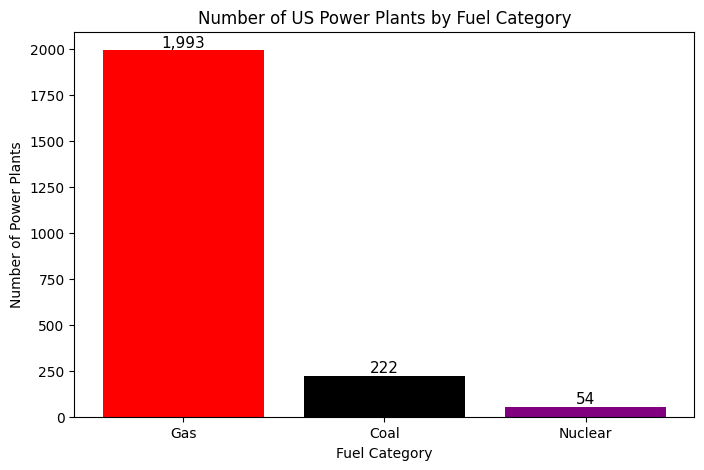

In [ ]:
fuel_counts = [len(df[df["fuel_category"] == fuel]) for fuel in selected_fuels]

plt.figure(figsize=(8, 5))
bars = plt.bar([fuel.title() for fuel in selected_fuels], fuel_counts, color=[color_map[fuel] for fuel in selected_fuels])
plt.xlabel("Fuel Category")
plt.ylabel("Number of Power Plants")
plt.title("Number of US Power Plants by Fuel Category")

# Add count labels on top of bars
for bar, count in zip(bars, fuel_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{count:,}", ha='center', va='bottom', fontsize=11)

plt.show()

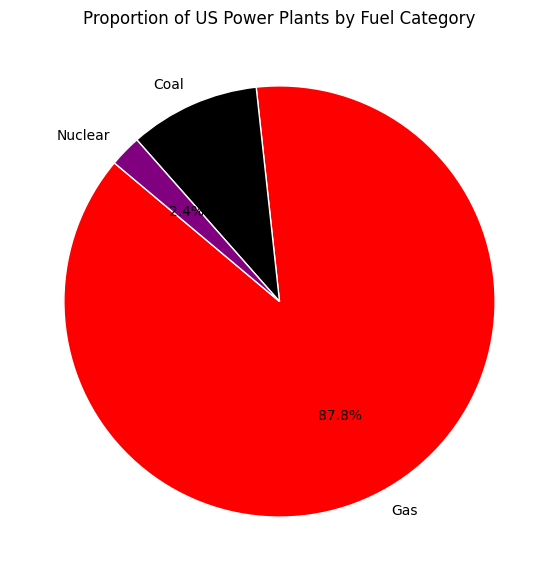

In [5]:
plt.figure(figsize=(7, 7))
plt.pie(
    fuel_counts,
    labels=[fuel.title() for fuel in selected_fuels],
    colors=[color_map[fuel] for fuel in selected_fuels],
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(edgecolor='w')
)
plt.title("Proportion of US Power Plants by Fuel Category")
plt.show()